In [1]:
import numpy as np
from datascience import *
path_data = 'https://github.com/data-8/textbook/raw/gh-pages/data/'
all_sales = Table.read_table(path_data + 'house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition',
    'Normal').select('SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 
    'Lot Area', 'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


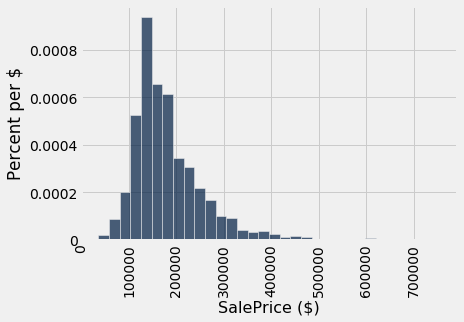

In [2]:
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
sales.hist('SalePrice', bins=32, unit='$')

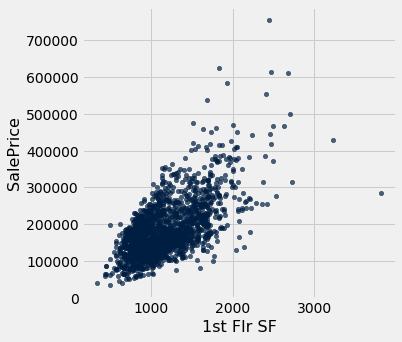

In [3]:
sales.scatter('1st Flr SF', 'SalePrice')

In [4]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t',
          correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.6424662541030225
Correlation of 2nd Flr SF and SalePrice:	 0.3575218942800824
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757169
Correlation of Garage Area and SalePrice:	 0.6385944852520443
Correlation of Wood Deck SF and SalePrice:	 0.3526986661950492
Correlation of Open Porch SF and SalePrice:	 0.3369094170263733
Correlation of Lot Area and SalePrice:	 0.2908234551157694
Correlation of Year Built and SalePrice:	 0.5651647537135916
Correlation of Yr Sold and SalePrice:	 0.02594857908072111


In [5]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors',
      both_floors), 'SalePrice', 'Both Floors')

0.7821920556134877

In [6]:
train, test = sales.split(1001)
print(train.num_rows, 'training and',
    test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [7]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: Row(1st Flr SF=897, 2nd Flr SF=0, Total Bsmt SF=876.0, Garage Area=264.0, Wood Deck SF=0, Open Porch SF=0, Lot Area=8665, Year Built=1968, Yr Sold=2007)
Using slopes: [ 9.33383893 11.10946696  9.71270344  9.29948905 10.86240085  8.68005884
  9.57206353  9.80311921  8.82001355]
Result: 139272.08312238153


In [8]:
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:',
       predict(example_slopes, example_row))

Actual sale price: 115000
Predicted sale price using random slopes: 139272.08312238153


In [9]:
train_prices = train.column(0)
train_attributes = train.drop(0)
def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:',
      rmse_train(example_slopes))

RMSE of all training examples using random slopes: 63970.098907489504


In [10]:
best_slopes = minimize(rmse_train, 
    start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:',
        rmse_train(best_slopes))

The best slopes for the training set:


/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1048: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
69.2031,75.186,51.6933,41.7921,33.336,31.5521,1.22156,529.783,-527.641


RMSE of all training examples using the best slopes: 31074.572851167875


In [11]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 31876.061362588185


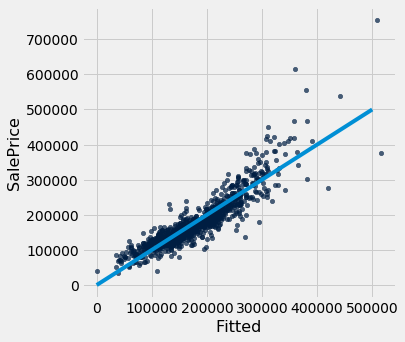

In [12]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

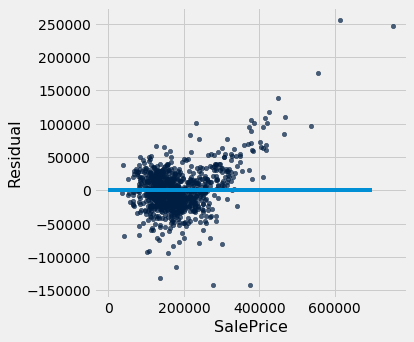

In [13]:
test.with_column('Residual', 
  test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);